# Отток клиентов

## Подготовка данных

### Общий взгляд на датасет, избавление от лишнего

In [91]:
# загружаем библиотеки
import pandas as pd
import numpy
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [92]:
warnings.filterwarnings('ignore')

In [93]:
#читаем файл и смотрим на него
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Числовые признаки перемешаны с категориальными. Поэтому проведем предварительную обработку методом прямого кодирования. Также в столбце Tenure есть пропуски, их тоже необходимо убрать. Некоторые признаки можно удалить из таблицы, так как они не несут никакого смысла для целевого параметра.

In [95]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### Работа с пропусками

In [96]:
# изучим природу пропусков 
print(data['Tenure'].value_counts())
data.query('Tenure == "Nan"')

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Сложно сказать, чем заменить пропуски в данной датасете. Правильнее всего было бы уточнить у заказчика. Явной замены здесь нет, обьекты с пропусками разнообразны по признакам. Отбросить 10% данных из-за одного пропуска тоже не уместно. Наиболее вероятная замена 0. Скорее всего это клиенты, которые в банке меньше года.


In [97]:
data['Tenure']= data['Tenure'].fillna(0)

### Подготовка данных для модели (прямое кодирование, деление выборок, мастабирование)

In [98]:
data_new = pd.get_dummies(data, drop_first=True)

Также числовые признаки выражены в разных масштабах, к примеру, balance может измеряться в сотнях тысячах, тогда как возраст это цифра двузначная. Применим мастабирование к датасету. Но сначала паделим его на обучающую, валидационную и тестовую выборки.

In [99]:
features = data_new.drop('Exited', axis=1)
target = data_new['Exited']

features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.4, random_state=100)
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5, random_state=100)

#проверим размер
features_train.shape, features_valid.shape, features_test.shape

((6000, 11), (2000, 11), (2000, 11))

In [100]:
# переходим к масштабированию
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scale = StandardScaler()
scale.fit(features_train[numeric])


features_train[numeric] = scale.transform(features_train[numeric])
features_valid[numeric] = scale.transform(features_valid[numeric])
features_test[numeric]= scale.transform(features_test[numeric])

Данные готовы для обучения и оценивания моделей.

## Исследование задачи

###  Изучение моделей при дисбалансе

In [101]:
# узнаем долю по оттоку клиентов
sum(data['Exited'])/len(data_new)


0.2037

Всего лишь 20% выборки имеет положительный ответ, скорее всего этого будет мало, чтобы получить качественную модель. Однако изучим, сначала как того требует проект, модели на несбалансированной выборке.

In [102]:
#дерево решений
best_result=0
best_depth=0
for i in range(1,15):
    model = DecisionTreeClassifier(random_state=100, max_depth=i)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    result= f1_score(target_valid, predictions)
    if result>best_result:
        best_result= result
        best_depth=i
        
best_result, best_depth 

(0.5766312594840667, 7)

Лучший результат дерева решений при глубине 7. Метрика на приемлимом уровне.

In [103]:
# случайный лес
best_result=0
best_depth=0
best_estimators = 0
for i in range(1,15):
    for a in range(10,80,10):
        model = RandomForestClassifier(random_state=100, max_depth=i, n_estimators=a)
        model.fit(features_train,target_train)
        predictions = model.predict(features_valid)
        result= f1_score(target_valid, predictions)
        if result>best_result:
            best_result= result
            best_depth=i
            best_estimators =a
        
best_result, best_depth, best_estimators

(0.6070287539936102, 12, 60)

Лучший результат случайного леса при глубине 12 и количестве деревьев 60. Результат f1 уже на приемлимом уровне - 0,61.

In [104]:
#логистическая регрессия

model = LogisticRegression(random_state=100, solver='liblinear')
model.fit(features_train,target_train)
predictions = model.predict(features_valid)
result= f1_score(target_valid, predictions)
result

0.3074003795066414

У логистической регрессии худший показатель.

## Борьба с дисбалансом

###  Балансирование моделей c гиперпараметром class_weight

In [105]:
# посмотрим как поменяются результаты, если сбалансировать классы
# начнем с гиперпараметра class_weight
#логистическая регрессия
model = LogisticRegression(random_state=100, solver='liblinear', class_weight='balanced')
model.fit(features_train,target_train)
predictions = model.predict(features_valid)
result= f1_score(target_valid, predictions)
result


0.5119152691968225

Все же резузьтат логистической регрессии оставляет желать лучшего. Ее дальше проверять нет смысла.

In [106]:
#дерево решений
best_result=0
best_depth=0
for i in range(1,15):
    model = DecisionTreeClassifier(random_state=100, max_depth=i, class_weight='balanced')
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    result= f1_score(target_valid, predictions)
    if result>best_result:
        best_result= result
        best_depth=i        

best_result, best_depth

(0.5720620842572062, 8)

Удивительно, но меткрика f1 немного сократилась у дерева решений. Хотя бы уже нет ошибок про 0 f1. Значит другие варианты в цикле в целом улучшились, но мы все таки ищем лучшую модель.

In [107]:
# случайный лес
best_result=0
best_depth=0
best_estimators = 0
for i in range(1,15):
    for a in range(10,80,10):
        model = RandomForestClassifier(random_state=100, max_depth=i, n_estimators=a, class_weight='balanced')
        model.fit(features_train,target_train)
        predictions = model.predict(features_valid)
        result= f1_score(target_valid, predictions)
        if result>best_result:
            best_result= result
            best_depth=i
            best_estimators =a
        
best_result, best_depth, best_estimators

(0.6281407035175879, 10, 60)

Случайному лесу балансировка классов пошла явно на пользу. Ушли ошибки 0 f1 метрики. Показатель метрики стал лучше и достиг 0,63.

### Балансирование моделей методом увеличения выборки

In [130]:
# создадим выборки с  увеличеными положительными ответами
features_train_0 = features_train[target_train==0]
features_train_1 = features_train[target_train==1]
target_train_0 = target_train[target_train==0]
target_train_1 = target_train[target_train==1]

target_up = pd.concat([target_train_0]+[target_train_1]*5)
features_up = pd.concat([features_train_0]+[features_train_1]*5)

features_up, target_up = shuffle(features_up, target_up, random_state=100)


In [131]:
#дерево решений
best_result=0
best_depth=0
for i in range(1,15):
    model = DecisionTreeClassifier(random_state=100, max_depth=i)
    model.fit(features_up, target_up)
    predictions = model.predict(features_valid)
    result= f1_score(target_valid, predictions)
    if result>best_result:
        best_result= result
        best_depth=i        

best_result, best_depth

(0.550408719346049, 5)

Дерево стало хуже предсказывать при таком подходе.

In [132]:
# случайный лес
best_result=0
best_depth=0
best_estimators = 0
for i in range(1,15):
    for a in range(10,80,10):
        model = RandomForestClassifier(random_state=100, max_depth=i, n_estimators=a)
        model.fit(features_up, target_up)
        predictions = model.predict(features_valid)
        result= f1_score(target_valid, predictions)
        if result>best_result:
            best_result= result
            best_depth=i
            best_estimators =a
        
best_result, best_depth, best_estimators

(0.6253101736972706, 13, 50)

Лес тоже стал хуже предсказывать при увеличение выборки.

### Балансирование моделей методом уменьшения выборки

In [136]:
# создадим выборки с уменьшенными отрицательными  ответами
target_down = pd.concat([target_train_0.sample(frac=0.4, random_state=100)]+[target_train_1])
features_down = pd.concat([features_train_0.sample(frac=0.4, random_state=100)]+[features_train_1])

features_down, target_down = shuffle(features_down, target_down, random_state=100)


In [137]:
#дерево решений
best_result=0
best_depth=0
for i in range(1,15):
    model = DecisionTreeClassifier(random_state=100, max_depth=i)
    model.fit(features_down, target_down)
    predictions = model.predict(features_valid)
    result= f1_score(target_valid, predictions)
    if result>best_result:
        best_result= result
        best_depth=i        

best_result, best_depth

(0.5746835443037974, 6)

Для дерева данный метод оказался лучшим. проверим его на случайном лесе.

In [138]:
# случайный лес
best_result=0
best_depth=0
best_estimators = 0
for i in range(1,15):
    for a in range(10,80,10):
        model = RandomForestClassifier(random_state=100, max_depth=i, n_estimators=a)
        model.fit(features_down, target_down)
        predictions = model.predict(features_valid)
        result= f1_score(target_valid, predictions)
        if result>best_result:
            best_result= result
            best_depth=i
            best_estimators =a
        
best_result, best_depth, best_estimators

(0.6355382619974059, 9, 70)

Данный метод оказался самым лучшим и для случайного леса, дава самый высокий показатель метрики f1. Данную модель будем использовать как итоговый вариант.

## Тестирование модели

In [140]:
# собираем воедино обучающую и валидационную выборку
features_trainvalid = pd.concat([features_train] + [features_valid])
target_trainvalid = pd.concat([target_train] + [target_valid])

# уменьшаем выборку (да понимаю тут функция бы и пригодилась, но быстрее уже ручками будет:)
features_trainvalid_0 = features_trainvalid[target_trainvalid==0]
features_trainvalid_1 = features_trainvalid[target_trainvalid==1]
target_trainvalid_0 = target_trainvalid[target_trainvalid==0]
target_trainvalid_1 = target_trainvalid[target_trainvalid==1]

target_trainvalid_down = pd.concat([target_trainvalid_0.sample(frac=0.4, random_state=100)]+[target_trainvalid_1])
features_trainvalid_down = pd.concat([features_trainvalid_0.sample(frac=0.4, random_state=100)]+[features_trainvalid_1])

features_trainvalid_down, target_trainvalid_down = shuffle(features_trainvalid_down, target_trainvalid_down, random_state=100)


In [141]:
# тестируем итоговую модель
model = RandomForestClassifier(random_state=100, max_depth=11, n_estimators=30)
model.fit(features_trainvalid_down, target_trainvalid_down)
predictions = model.predict(features_test)
result= f1_score(target_test, predictions)

result

0.6031746031746033

Модель прошла тест метрика f1 = 0.6032. Посмотрим результат метрики AUC-ROC для этой модели.

In [142]:
predictions_proba = model.predict_proba(features_test)
auc = roc_auc_score(target_test, predictions_proba[:,1])
auc

0.8496111864164944

Метрика составляет 0,8496 что явно лучше результата случайной модели, у которой метрика равняется 0,5. значит данная модель обладает высоким качеством. Она не совершенна, но данное значение говорит, что она часто угадывает истенно положительные ответы и нечасто дает ложно положительные.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], <a list of 11 Text xticklabel objects>)

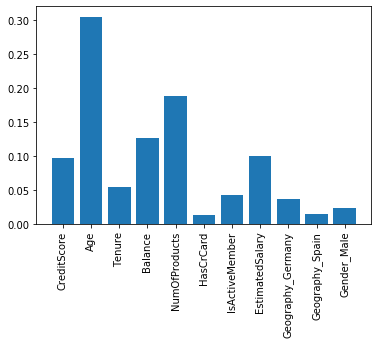

In [143]:
model = RandomForestClassifier(random_state=100, max_depth=11, n_estimators=30)
model.fit(features_up, target_up)
imp=pd.Series(model.feature_importances_, index=features_train.columns)

plt.figsize=(30,20)
plt.bar(imp.index, imp)
plt.xticks(rotation=90)

## Итоговый вывод

Лучшей моделью с наибольшей метрикой f1 (0.5993) стала модель случайного леса, которая была обучена на выборке методом увеличения положительных ответов. Лучшие гиперпараметры этой модели: глубина -11 и количество деревьев - 30. AUC-ROC данной модели тоже достаточно высок, что дает большую уверенность в работе данной модели.
